In [2]:
# Install dependencies (run once; requirements.txt in project root)
import subprocess
import sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "-r", "../requirements.txt"])


[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


0

In [3]:
# imports & constants
import gzip
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_ROOT = Path("../data")
SYMBOL = "btcusdt"

# Предсказание доходности midprice на 1 секунду

**Цель:** по котировкам стакана (BBO) и сделкам предсказать доходность midprice на горизонте 1 с.  
**Данные:** BBO (best bid / best ask) и трейды; midprice = (bid + ask) / 2; таргет = (mid_{t+1} − mid_t) / mid_t.  
**Содержание:** визуализация BBO и трейдов, загрузка, EDA, расчёт таргета, фичи из конфига, линейная модель и итоговый саммари.

*Воспроизведение: в первой ячейке заданы `DATA_ROOT` и `SYMBOL`; зависимости — `requirements.txt` в корне проекта.*

## Введение для читателей

### Что такое ордербук (order book)

**Ордербук** — это список заявок на покупку и продажу актива на бирже в реальном времени. С одной стороны — **биды** (bid): заявки на покупку с указанием цены и объёма. С другой — **аски** (ask): заявки на продажу. Заявки упорядочены по цене: лучшая цена покупки — самый высокий bid, лучшая цена продажи — самый низкий ask. Разница между ними называется **спредом** (spread).

В этом ноутбуке мы работаем не с полным стаканом, а с **BBO** (Best Bid and Offer) — лучшей парой цен на каждый момент времени: один лучший bid и один лучший ask (и объёмы по ним). По ним считаем **midprice** = (best bid + best ask) / 2 — условная «середина» рынка. Когда происходят **сделки** (trades), они исполняются по этим ценам: покупка по ask, продажа по bid. Ниже мы загружаем два типа данных: **котировки BBO** (как меняются лучшие bid/ask во времени) и **сделки** (когда, по какой цене и в каком объёме прошла сделка).

### Колонки в датасете

**Quotes (котировки BBO)** — одна строка на каждое обновление лучших bid/ask:

| Колонка | Описание |
|--------|----------|
| `exchange` | Идентификатор биржи/продукта (например, bybit-linear) |
| `symbol` | Торговая пара (например, ETHUSDT) |
| `timestamp` | Время события на бирже, микросекунды (UTC) |
| `event_timestamp` | Время получения сообщения, мкс |
| `local_timestamp` | Время на стороне коллектора, мкс |
| `is_snapshot` | Является ли сообщение полным снимком стакана (True) или инкрементальным обновлением |
| `ask_price` | Лучшая цена продажи (минимальный ask) |
| `ask_amount` | Объём на лучшей цене продажи |
| `bid_price` | Лучшая цена покупки (максимальный bid) |
| `bid_amount` | Объём на лучшей цене покупки |

В коде дополнительно считаются: **midprice** = (bid_price + ask_price) / 2 и **ts** — время в формате datetime (из `timestamp`).

**Trades (сделки)** — одна строка на каждую исполненную сделку:

| Колонка | Описание |
|--------|----------|
| `exchange` | Идентификатор биржи/продукта |
| `symbol` | Торговая пара |
| `timestamp` | Время сделки на бирже, мкс |
| `event_timestamp` | Время сообщения, мкс |
| `local_timestamp` | Время на стороне коллектора, мкс |
| `trade_id` | Уникальный идентификатор сделки |
| `side` | Сторона: buy (покупка) или sell (продажа) |
| `price` | Цена исполнения |
| `amount` | Объём сделки |

## Структура данных и загрузка

**Quotes** (стакан): `timestamp` (мкс), `bid_price`, `ask_price`, `bid_amount`, `ask_amount`. **Midprice** = (bid_price + ask_price) / 2.  
**Trades:** `timestamp`, `side`, `price`, `amount`.  
Данные: одна дата из `{DATA_ROOT}/bybit-linear/` (первая доступная), файлы `quotes.gz` и `trades.gz` в `{дата}/{SYMBOL}/`. Трейн — первые 12 ч дня, тест — вторые 12 ч.

In [4]:
base = DATA_ROOT / "bybit-linear"
date = "2026-02-19"
path_q = base / date / SYMBOL.lower() / "quotes.gz"
path_t = base / date / SYMBOL.lower() / "trades.gz"

def read_gz(path, cols, num_cols):
    if not path.exists():
        return pd.DataFrame(columns=cols)
    df = pd.read_csv(gzip.open(path, "rt"), names=cols, skiprows=1)
    for c in ["timestamp", "event_timestamp", "local_timestamp"] + num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

COLS_Q = ["exchange", "symbol", "timestamp", "event_timestamp", "local_timestamp",
          "is_snapshot", "ask_amount", "ask_price", "bid_price", "bid_amount"]
COLS_T = ["exchange", "symbol", "timestamp", "event_timestamp", "local_timestamp",
          "trade_id", "side", "price", "amount"]
quotes = read_gz(path_q, COLS_Q, ["ask_price", "bid_price", "ask_amount", "bid_amount"])
quotes["midprice"] = (quotes["ask_price"] + quotes["bid_price"]) / 2
quotes["ts"] = pd.to_datetime(quotes["timestamp"], unit="us", utc=True)
quotes = quotes.dropna(subset=["midprice", "timestamp"])

trades = read_gz(path_t, COLS_T, ["price", "amount"])
trades["ts"] = pd.to_datetime(trades["timestamp"], unit="us", utc=True)
trades = trades.dropna(subset=["price", "timestamp"])

print(date, "| quotes:", quotes.shape, "| trades:", trades.shape)
quotes.head()

2026-02-19 | quotes: (2539181, 12) | trades: (2304876, 10)


,exchange,symbol,timestamp,event_timestamp,local_timestamp,is_snapshot,ask_amount,ask_price,bid_price,bid_amount,midprice,ts
0,bybit-linear,btcusdt,1771459200305000,0,1771459200391486,True,0.366,66433.0,66432.9,5.151,66432.95,2026-02-19 00:00:00.305000+00:00
1,bybit-linear,btcusdt,1771459200315000,0,1771459200401626,True,0.364,66433.0,66432.9,5.151,66432.95,2026-02-19 00:00:00.315000+00:00
2,bybit-linear,btcusdt,1771459200326000,0,1771459200411714,True,0.432,66433.0,66432.9,5.151,66432.95,2026-02-19 00:00:00.326000+00:00
3,bybit-linear,btcusdt,1771459200356000,0,1771459200441609,True,0.981,66433.0,66432.9,5.151,66432.95,2026-02-19 00:00:00.356000+00:00
4,bybit-linear,btcusdt,1771459200367000,0,1771459200452787,True,0.982,66433.0,66432.9,5.151,66432.95,2026-02-19 00:00:00.367000+00:00


## Одна картинка: BBO и трейды

На одном графике — лучший bid, лучший ask (линии) и сделки (точки: зелёные — покупки, красные — продажи). Видно, как стакан двигается во времени и где происходят исполнения.

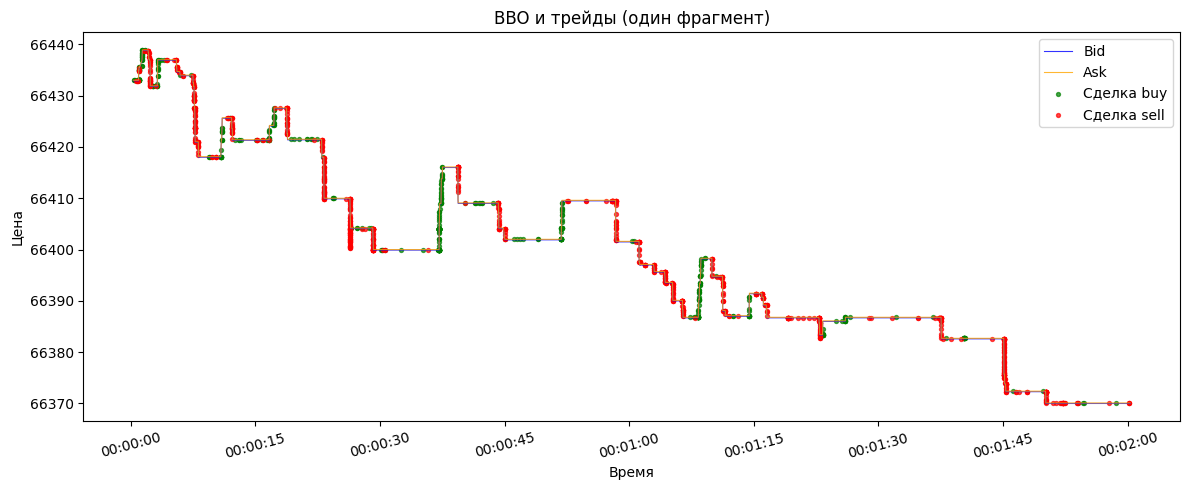

In [5]:
# Короткое окно для наглядности (параметры не привязаны к конкретным данным)
t0 = quotes["ts"].min()
window = pd.Timedelta(minutes=2)
q = quotes[(quotes["ts"] >= t0) & (quotes["ts"] < t0 + window)].copy()
tr = trades[(trades["ts"] >= t0) & (trades["ts"] < t0 + window)].copy()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(q["ts"], q["bid_price"], label="Bid", color="blue", alpha=0.8, lw=0.8)
ax.plot(q["ts"], q["ask_price"], label="Ask", color="orange", alpha=0.8, lw=0.8)
if len(tr) > 0:
    buy = tr[tr["side"] == "buy"]
    sell = tr[tr["side"] == "sell"]
    if len(buy) > 0:
        ax.scatter(buy["ts"], buy["price"], c="green", s=8, alpha=0.7, label="Сделка buy")
    if len(sell) > 0:
        ax.scatter(sell["ts"], sell["price"], c="red", s=8, alpha=0.7, label="Сделка sell")
ax.set_xlabel("Время")
ax.set_ylabel("Цена")
ax.legend(loc="upper right")
ax.set_title("BBO и трейды (один фрагмент)")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## Разведка данных (EDA)

In [6]:
# Типы и базовая статистика (колонки зависят от загруженных данных)
quotes.dtypes
quotes.describe()

,timestamp,event_timestamp,local_timestamp,ask_amount,ask_price,bid_price,bid_amount,midprice
count,2.539181e+06,2539181.0,2.539181e+06,2.539181e+06,2.539181e+06,2.539181e+06,2.539181e+06,2.539181e+06
mean,1.771502e+15,0.0,1.771502e+15,2.223871e+00,6.664480e+04,6.664469e+04,2.573210e+00,6.664474e+04
std,2.298079e+10,0.0,2.298079e+10,2.303751e+00,3.523655e+02,3.523675e+02,3.016847e+00,3.523665e+02
min,1.771459e+15,0.0,1.771459e+15,1.000000e-03,6.558330e+04,6.557700e+04,1.000000e-03,6.558285e+04
25%,1.771483e+15,0.0,1.771483e+15,5.940000e-01,6.639380e+04,6.639370e+04,6.990000e-01,6.639375e+04
50%,1.771505e+15,0.0,1.771505e+15,1.549000e+00,6.674730e+04,6.674720e+04,1.734000e+00,6.674725e+04
75%,1.771520e+15,0.0,1.771520e+15,3.051000e+00,6.691360e+04,6.691350e+04,3.576000e+00,6.691355e+04
max,1.771546e+15,0.0,1.771546e+15,5.474500e+01,6.730000e+04,6.729990e+04,2.454160e+02,6.729995e+04


Временной диапазон: 2026-02-19 00:00:00.305000+00:00 — 2026-02-20 00:00:00.407000+00:00


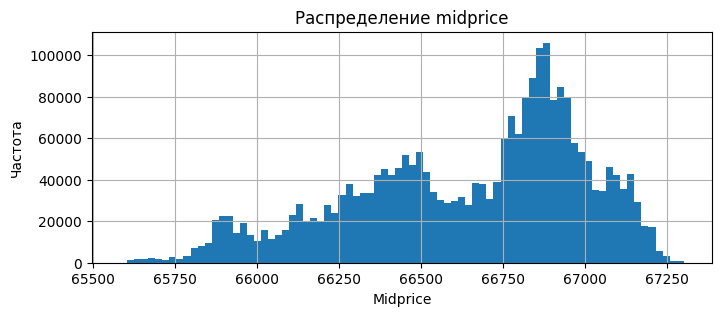

In [7]:
# Период и распределение midprice (всё из данных)
print("Временной диапазон:", quotes["ts"].min(), "—", quotes["ts"].max())
quotes["midprice"].hist(bins=80, figsize=(8, 3));
plt.xlabel("Midprice");
plt.ylabel("Частота");
plt.title("Распределение midprice");

In [8]:
# Спред из колонок ask/bid
quotes["spread"] = quotes["ask_price"] - quotes["bid_price"]
quotes["spread"].describe()

count    2.539181e+06
mean     1.094258e-01
std      2.281835e-01
min      1.000000e-01
25%      1.000000e-01
50%      1.000000e-01
75%      1.000000e-01
max      5.530000e+01
Name: spread, dtype: float64

**Итог EDA:** объём наблюдений и период — в выводе ячеек выше; распределения midprice и спреда визуализированы.

## Расчёт таргета

Агрегируем котировки в 1-секундные бары (последний midprice в секунду). **Таргет** = доходность midprice через 1 с: `(mid_{t+1} - mid_t) / mid_t`. Число баров с таргетом задаёт объём выборки (см. ячейку ниже).

In [9]:
# Ресемплинг в 1s (последняя цена в секунду); таргет = forward return
quotes_1s = quotes.set_index("ts").resample("1s").agg({
    "midprice": "last",
    "ask_price": "last",
    "bid_price": "last",
    "ask_amount": "last",
    "bid_amount": "last",
}).dropna()

# Таргет: доходность через 1 секунду (shift(-1) = следующая секунда)
quotes_1s["target"] = quotes_1s["midprice"].pct_change(periods=1).shift(-1)
quotes_1s = quotes_1s.dropna(subset=["target"])
print("Число 1s-баров с таргетом:", quotes_1s.shape[0])
quotes_1s.head(10)

Число 1s-баров с таргетом: 86122


,midprice,ask_price,bid_price,ask_amount,bid_amount,target
ts,,,,,,
2026-02-19 00:00:00+00:00,66435.45,66435.5,66435.4,0.003,2.796,0.000051
2026-02-19 00:00:01+00:00,66438.85,66438.9,66438.8,1.230,5.871,-0.000105
2026-02-19 00:00:02+00:00,66431.85,66431.9,66431.8,0.007,2.274,0.000077
2026-02-19 00:00:03+00:00,66436.95,66437.0,66436.9,0.211,5.263,0.000000
2026-02-19 00:00:04+00:00,66436.95,66437.0,66436.9,0.160,5.252,-0.000045
2026-02-19 00:00:05+00:00,66433.95,66434.0,66433.9,4.323,0.354,0.000000
2026-02-19 00:00:06+00:00,66433.95,66434.0,66433.9,4.891,0.148,-0.000196
2026-02-19 00:00:07+00:00,66420.95,66421.0,66420.9,6.346,0.290,-0.000044
2026-02-19 00:00:08+00:00,66418.05,66418.1,66418.0,1.909,0.121,0.000000


## Feature engineering

Конфиг **FEATURES**: для каждой фичи заданы имя, описание и функция расчёта. Добавление новой фичи — одна строка в конфиге; расчёт, список колонок и визуализация строятся автоматически.

In [10]:
# Фичи: имя -> (описание, функция). В названиях rolling_5s_* — окно 5 секунд.
FEATURES = {
    "spread_bps": (
        "спред в базисных пунктах",
        lambda d: 1e4 * (d["ask_price"] - d["bid_price"]) / d["midprice"],
    ),
    "imbalance": (
        "дисбаланс объёмов bid/ask на лучшем уровне",
        lambda d: (d["bid_amount"] - d["ask_amount"]) / (d["bid_amount"] + d["ask_amount"] + 1e-12),
    ),
    "return_1s": (
        "доходность midprice за последнюю 1 с",
        lambda d: d["midprice"].pct_change(1),
    ),
    "rolling_5s_volatility": (
        "волатильность доходности за 5 с (std)",
        lambda d: d["midprice"].pct_change().rolling(5).std(),
    ),
    "rolling_5s_momentum": (
        "импульс за 5 с (сумма доходностей)",
        lambda d: d["midprice"].pct_change().rolling(5).sum(),
    ),
    "rolling_5s_mean_return": (
        "средняя доходность за 5 с",
        lambda d: d["midprice"].pct_change().rolling(5).mean(),
    ),
    "rolling_5s_price_range": (
        "размах цены за 5 с (доля от midprice)",
        lambda d: (d["midprice"].rolling(5).max() - d["midprice"].rolling(5).min()) / d["midprice"],
    ),
    "spread_change_bps": (
        "изменение спреда в б.п. к предыдущему бару",
        lambda d: (d["ask_price"] - d["bid_price"]).diff() * 1e4 / d["midprice"],
    ),
    "log_volume_ratio": (
        "лог отношения объёмов bid/ask",
        lambda d: np.log((d["bid_amount"] + 1e-6) / (d["ask_amount"] + 1e-6)),
    ),
    "total_volume": (
        "суммарный объём на лучших уровнях",
        lambda d: d["bid_amount"] + d["ask_amount"],
    ),
    "return_acceleration_1s": (
        "ускорение доходности (изменение за 1 с минус за 2 с)",
        lambda d: d["midprice"].pct_change(1) - d["midprice"].pct_change(2),
    ),
}

df = quotes_1s.copy()
for name, (_, fn) in FEATURES.items():
    df[name] = fn(df)
df = df.dropna()

# Трейн: первые 12 ч, тест: вторые 12 ч
split_ts = df.index.min() + pd.Timedelta(hours=12)
mask_train = (df.index < split_ts) & (df["target"] != 0)
mask_test = (df.index >= split_ts) & (df["target"] != 0)
df_train = df[mask_train]
df_test = df[mask_test]
print("Train:", len(df_train), "| Test:", len(df_test))

feature_cols = list(FEATURES.keys())
feature_descriptions = {k: v[0] for k, v in FEATURES.items()}
df[feature_cols].describe()

Train: 11917 | Test: 20562


,spread_bps,imbalance,return_1s,rolling_5s_volatility,rolling_5s_momentum,rolling_5s_mean_return,rolling_5s_price_range,spread_change_bps,log_volume_ratio,total_volume,return_acceleration_1s
count,86117.000000,86117.000000,8.611700e+04,86117.000000,8.611700e+04,8.611700e+04,86117.000000,8.611700e+04,86117.000000,86117.000000,8.611700e+04
mean,0.015530,0.041070,9.827798e-08,0.000055,4.844607e-07,9.689214e-08,0.000120,-1.865892e-08,0.142865,4.734484,-9.841066e-08
std,0.021984,0.650608,8.194454e-05,0.000060,1.877303e-04,3.754606e-05,0.000147,3.109884e-02,2.439719,3.096778,8.194454e-05
min,0.014859,-0.999848,-1.522417e-03,0.000000,-1.687258e-03,-3.374516e-04,0.000000,-2.835707e+00,-9.482265,0.002000,-1.917564e-03
25%,0.014940,-0.571199,0.000000e+00,0.000007,-7.067983e-05,-1.413597e-05,0.000000,0.000000e+00,-1.298602,2.788000,0.000000e+00
50%,0.014967,0.062999,0.000000e+00,0.000042,0.000000e+00,0.000000e+00,0.000081,0.000000e+00,0.126165,4.043000,0.000000e+00
75%,0.015036,0.665712,0.000000e+00,0.000081,7.180364e-05,1.436073e-05,0.000178,0.000000e+00,1.606002,6.068000,0.000000e+00
max,2.849789,0.999835,1.917861e-03,0.000893,2.398227e-03,4.796454e-04,0.002540,2.834790e+00,9.402932,187.956000,1.522599e-03


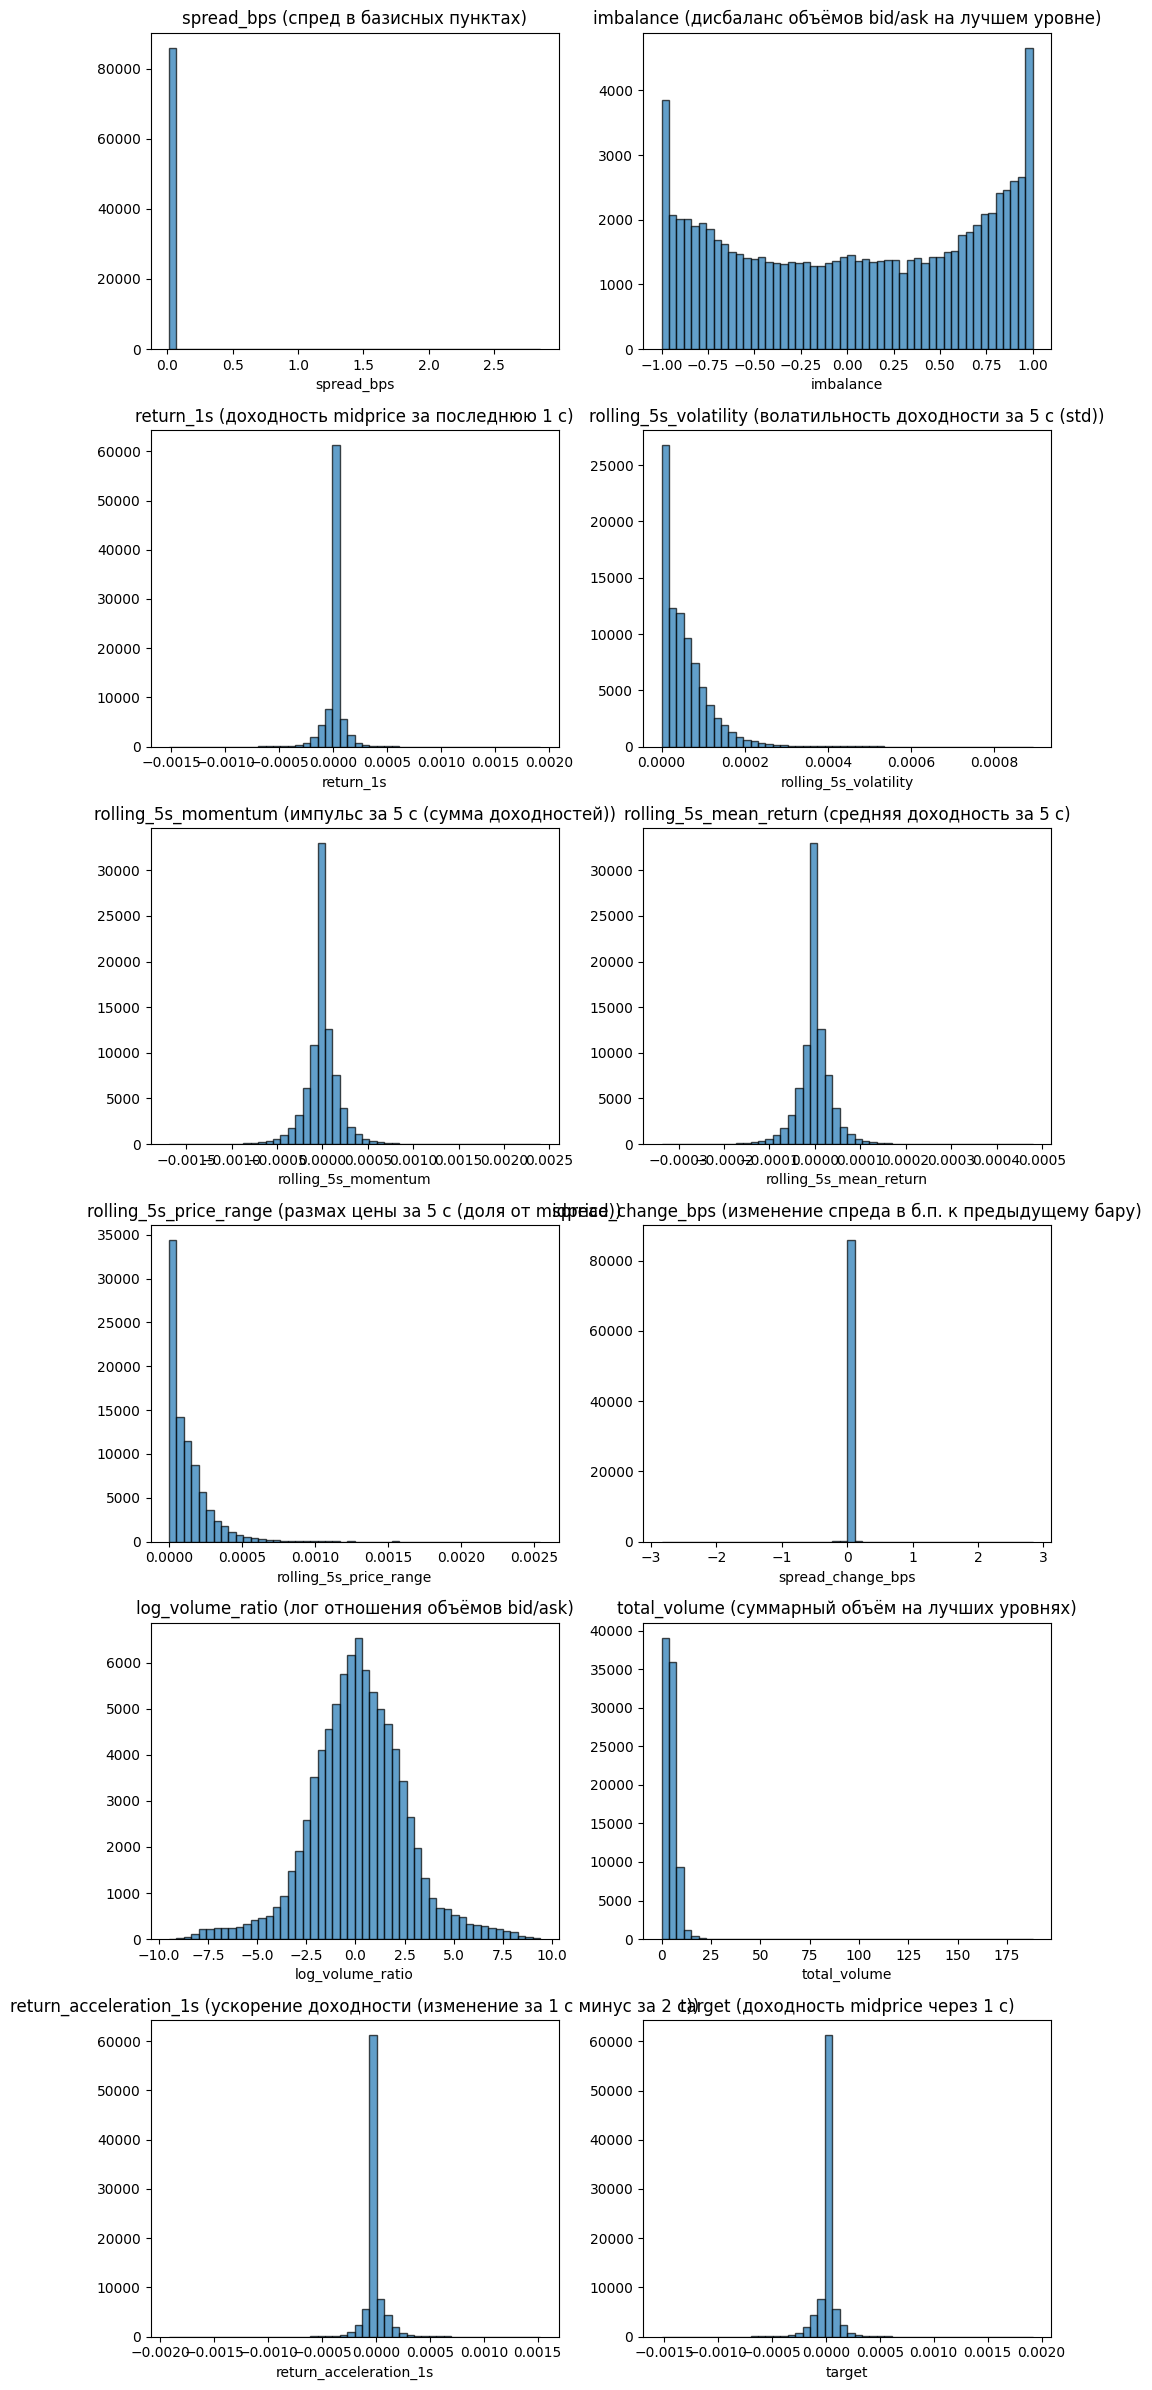

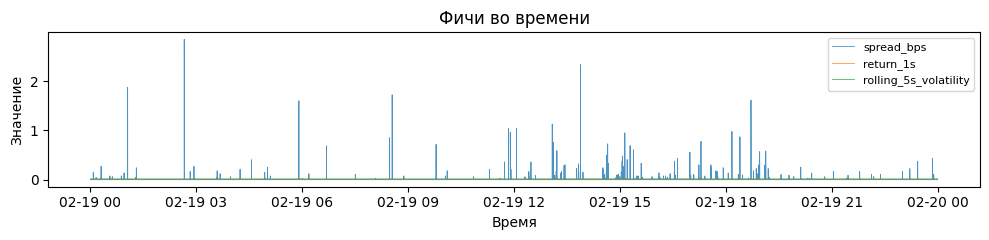

In [11]:
# Визуализация всех фичей + таргет по конфигу (сетка подстраивается под число фичей)
cols_to_plot = feature_cols + ["target"]
descriptions = {**feature_descriptions, "target": "доходность midprice через 1 с"}
n = len(cols_to_plot)
ncols = 2
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
axes = np.atleast_2d(axes)
for i, col in enumerate(cols_to_plot):
    r, c = i // ncols, i % ncols
    axes[r, c].hist(df[col], bins=50, edgecolor="k", alpha=0.7)
    axes[r, c].set_title(f"{col} ({descriptions.get(col, col)})")
    axes[r, c].set_xlabel(col)
for j in range(n, nrows * ncols):
    axes.flat[j].set_visible(False)
plt.tight_layout()
plt.show()

# Фичи во времени (небольшой график)
cols_time = ["spread_bps", "return_1s", "rolling_5s_volatility"]
cols_time = [c for c in cols_time if c in df.columns]
if cols_time:
    fig, ax = plt.subplots(figsize=(10, 2.5))
    for col in cols_time:
        ax.plot(df.index, df[col], label=col, alpha=0.8, linewidth=0.6)
    ax.set_xlabel("Время")
    ax.set_ylabel("Значение")
    ax.legend(loc="upper right", fontsize=8)
    ax.set_title("Фичи во времени")
    plt.tight_layout()
    plt.show()

## Линейная модель

Регрессия по фичам из конфига → таргет. Ниже: R², RMSE, коэффициенты и саммари для питча (метрика на вынос, лучший предиктор, ограничения, следующие шаги).

In [12]:
# Линейная регрессия: трейн первые 12 ч, оценка на тесте (вторые 12 ч)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X_train = df_train[feature_cols]
y_train = df_train["target"]
X_test = df_test[feature_cols]
y_test = df_test["target"]
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
coefs = pd.Series(model.coef_, index=feature_cols)
top_pred = coefs.abs().idxmax()

R² (тест): 0.09405071752896677
RMSE (тест): 0.00014015381543751334

Коэффициенты (по убыванию модуля):
return_acceleration_1s    4.000703e-02
rolling_5s_price_range    1.446864e-02
imbalance                 5.323682e-05
spread_change_bps         1.521824e-05
log_volume_ratio          2.131115e-06
total_volume             -5.379306e-07
spread_bps               -5.299163e-05
rolling_5s_mean_return   -7.317663e-04
rolling_5s_momentum      -3.658831e-03
rolling_5s_volatility    -1.791250e-02
return_1s                -1.021514e-01
dtype: float64

--- Итог ---
R² на тесте: 0.0941; лучший предиктор по |coef|: return_1s
Ограничения: один день, один горизонт таргета.
Дальше: другие фичи, бэктест, другие модели.


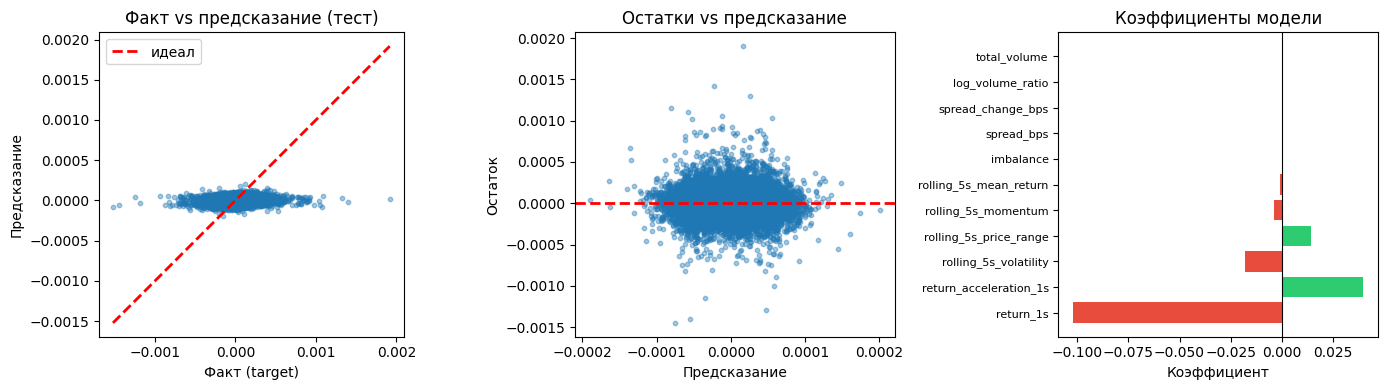

In [13]:
# Метрики и графики
print("R² (тест):", r2)
print("RMSE (тест):", rmse)
print("\nКоэффициенты (по убыванию модуля):")
print(coefs.sort_values(ascending=False))
print("\n--- Итог ---")
print(f"R² на тесте: {r2:.4f}; лучший предиктор по |coef|: {top_pred}")
print("Ограничения: один день, один горизонт таргета.")
print("Дальше: другие фичи, бэктест, другие модели.")

# Графики по тесту: факт vs предсказание, остатки, коэффициенты
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].scatter(y_test, y_pred, alpha=0.4, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2, label="идеал")
axes[0].set_xlabel("Факт (target)")
axes[0].set_ylabel("Предсказание")
axes[0].set_title("Факт vs предсказание (тест)")
axes[0].legend()
axes[0].set_aspect("equal", adjustable="box")

residuals = y_test - y_pred
axes[1].scatter(y_pred, residuals, alpha=0.4, s=10)
axes[1].axhline(0, color="red", linestyle="--", lw=2)
axes[1].set_xlabel("Предсказание")
axes[1].set_ylabel("Остаток")
axes[1].set_title("Остатки vs предсказание")

coef_sorted = coefs.reindex(coefs.abs().sort_values(ascending=False).index)
colors = ["#2ecc71" if c > 0 else "#e74c3c" for c in coef_sorted]
axes[2].barh(range(len(coef_sorted)), coef_sorted.values, color=colors)
axes[2].axvline(0, color="black", linewidth=0.8)
axes[2].set_yticks(range(len(coef_sorted)))
axes[2].set_yticklabels(coef_sorted.index, fontsize=8)
axes[2].set_xlabel("Коэффициент")
axes[2].set_title("Коэффициенты модели")
plt.tight_layout()
plt.show()

CatBoost R² (тест): 0.0883324120320238
CatBoost RMSE (тест): 0.00014059544150783938


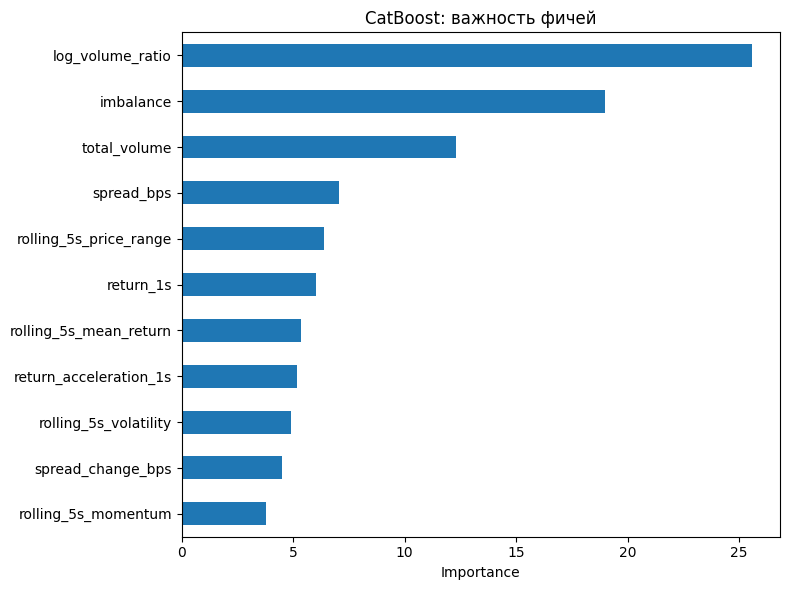

In [14]:
# CatBoost: трейн первые 12 ч, метрики на тесте
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error

cb = CatBoostRegressor(iterations=200, learning_rate=0.1, depth=4, verbose=0, random_state=42)
cb.fit(X_train, y_train)
y_pred_cb = cb.predict(X_test)
print("CatBoost R² (тест):", r2_score(y_test, y_pred_cb))
print("CatBoost RMSE (тест):", np.sqrt(mean_squared_error(y_test, y_pred_cb)))

imp = pd.Series(cb.get_feature_importance(), index=feature_cols).sort_values(ascending=True)
imp.plot(kind="barh", figsize=(8, 6), title="CatBoost: важность фичей")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Итог

По загруженным данным построены midprice и таргет; использованы фичи из конфига `FEATURES` (их число и названия задаются конфигом). Линейная модель: метрики R²/RMSE, лучший предиктор по коэффициенту, ограничения и следующие шаги — в выводе ячейки выше. При подстановке других данных (тот же формат) достаточно поменять `DATA_ROOT` и `SYMBOL`; список фичей и подписи к графикам берутся из конфига.